# Methodology for Question B
Detection of aberrant behavior in the phone's gyroscope readings is also a problem of anomaly detection. The steps involved in the approach are as follows:
1. Preprocessing - since the sensor data is obtained at discrete intervals of time, there could be instances of missing values. So, missing value imputation is essential
2. Anomaly detection in the gyroscope readings - unsupervised algorithms 
3. Sampling - split the time series data into train and test
4. Feature creation
5. Modelling - supervised (binary classification) algorithms. The DV (dependent variable) is 1 if a reading is anomalous (comes from step-2) else 0
6. Evaluation - metrics include AUC, precision, recall, f-score

In [61]:
import os, sys, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings  
warnings.filterwarnings('ignore')

In [59]:
# GLOBALS
LOCAL_ROOT = '/Users/lenovo/Documents/ExternalTest/Zendrive/'
RAW_DIR = os.path.join(LOCAL_ROOT, 'raw_data')
INTER_DIR = os.path.join(LOCAL_ROOT, 'inter_data')
MODEL_DIR = os.path.join(LOCAL_ROOT, 'model')
OUT_DIR = MODEL_DIR
GPS_FN = os.path.join(RAW_DIR, 'gps_test.csv')
MOTION_FN = os.path.join(RAW_DIR, 'motion_test.csv')

In [3]:
# read gps data
motion_df = pd.read_csv(MOTION_FN)

print(motion_df.shape)
motion_df.head()

(14671, 13)


,Unnamed: 0,timestamp,proximity,driver_id,pitch,gyroscope_y,gyroscope_x,gyroscope_z,acceleration_z,acceleration_y,acceleration_x,yaw,roll
0,1,1475693909361,-1,NzUxNWQwMjBk,0.040626,-0.028548,-0.008259,-0.001406,-0.183663,0.264476,0.326080,1.583115,0.747436
1,2,1475693909541,-1,NzUxNWQwMjBk,-0.439603,-0.018676,0.002345,0.004972,-0.368844,0.235645,-0.011001,2.124577,0.646496
2,3,1475693909721,-1,NzUxNWQwMjBk,-0.448445,0.004903,-0.017983,-0.003556,0.112644,0.226058,0.180560,2.116543,0.655507
3,4,1475693909901,-1,NzUxNWQwMjBk,-0.455960,0.009423,0.004332,-0.006797,-0.004901,0.102609,0.219669,2.109604,0.657661
4,5,1475693910082,-1,NzUxNWQwMjBk,-0.460388,-0.004245,0.011762,-0.006854,-0.065030,0.098155,0.217536,2.105369,0.662631


In [4]:
motion_df.drop('Unnamed: 0', axis=1, inplace=True)
motion_df['timestamp'] = pd.to_datetime(motion_df['timestamp'], unit='ms')
start = motion_df.loc[0, 'timestamp']
motion_df['time_diff'] = motion_df['timestamp'].apply(lambda x: int(((x - start).total_seconds())*1000))

In [5]:
np.unique(np.diff(motion_df['time_diff'].values))

array([179, 180, 181, 199, 200, 201, 202], dtype=int64)

## Step-1: Skipping the missing value imputation step as all of the observations are roughly obtained in an interval of 180-200 milliseconds

## Step-2: Anomaly detection in Gyroscope Readings

In [32]:
from sklearn.ensemble import IsolationForest

to_model_columns = ['gyroscope_x', 'gyroscope_y', 'gyroscope_z']

print('fit')
clf = IsolationForest(n_estimators=100, max_samples='auto', max_features=1.0, bootstrap=False, n_jobs=-1,
                      random_state=42, verbose=0, contamination=0.03)
%time clf.fit(motion_df[to_model_columns])

print('prediction')
pred = clf.predict(motion_df[to_model_columns])
motion_df['anomaly'] = pred
outliers = motion_df.loc[motion_df['anomaly'] == -1]
outlier_index = list(outliers.index)
print(motion_df['anomaly'].value_counts())

fit
Wall time: 24.6 s
prediction
 1    14230
-1      441
Name: anomaly, dtype: int64


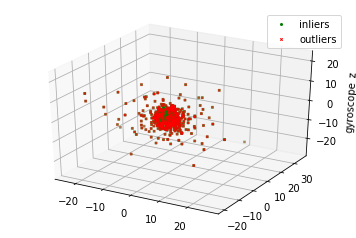

In [33]:
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

scaler = StandardScaler()

# normalize the gyroscope readings
X = scaler.fit_transform(motion_df[to_model_columns])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("gyroscope_z")

# Plot the compressed data points
ax.scatter(X[:, 0], X[:, 1], zs=X[:, 2], s=4, lw=1, label="inliers", c="green")

# Plot x's for the ground truth outliers
ax.scatter(X[outlier_index, 0], X[outlier_index, 1], X[outlier_index, 2],
           lw=1, s=6, marker="x", c="red", label="outliers")
ax.legend()

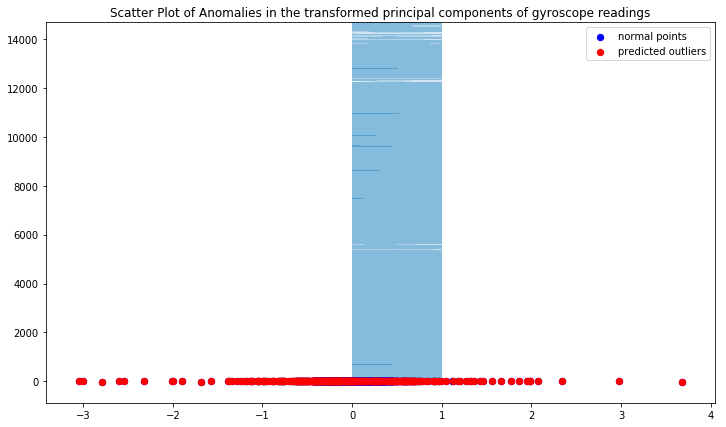

In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(motion_df[to_model_columns])

X = pd.DataFrame(pca.transform(motion_df[to_model_columns]))

Z = np.array(X)
figsize = (12, 7)
plt.figure(figsize=figsize)
plt.title("Scatter Plot of Anomalies in the transformed principal components of gyroscope readings")
plt.contourf( Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X[0], X[1], c='blue',
                 s=40, label="normal points")

b1 = plt.scatter(X.iloc[outlier_index, 0], X.iloc[outlier_index, 1], c='red',
                 s=40,  edgecolor="red", label="predicted outliers")
plt.legend(loc="upper right")

Text(0.5,0,u'Trip Time (ms)')

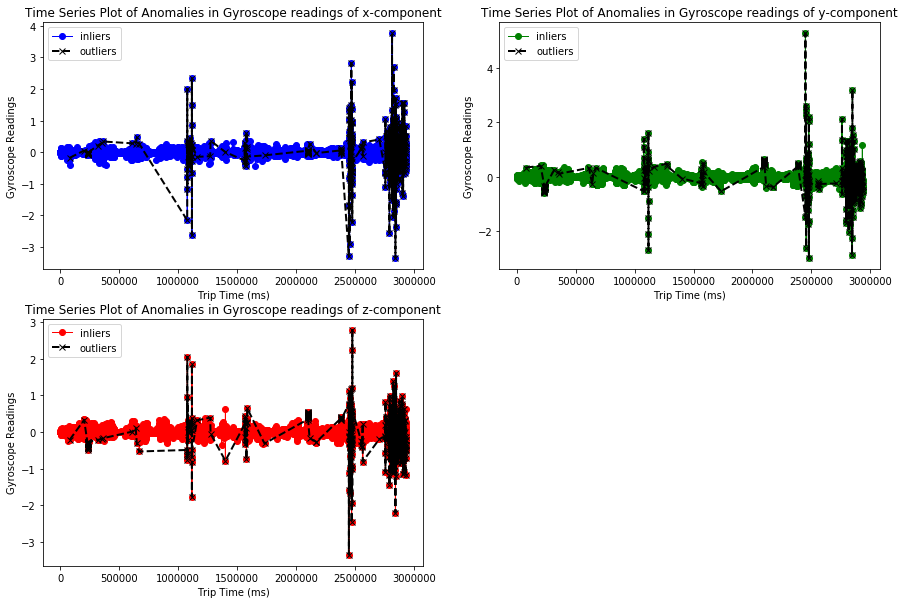

In [35]:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)

ax1.plot(motion_df['time_diff'].values, motion_df['gyroscope_x'], color='blue', marker='o', label='inliers',
        lw=1)
ax2.plot(motion_df['time_diff'].values, motion_df['gyroscope_y'], color='green', marker='o', label='inliers',
        lw=1)
ax3.plot(motion_df['time_diff'].values, motion_df['gyroscope_z'], color='red', marker='o', label='inliers',
        lw=1)
ax1.plot(motion_df.loc[outlier_index, 'time_diff'].values, motion_df.loc[outlier_index, 'gyroscope_x'],
        color='black', marker='x', label='outliers', lw=2, linestyle='dashed')
ax2.plot(motion_df.loc[outlier_index, 'time_diff'].values, motion_df.loc[outlier_index, 'gyroscope_y'],
        color='black', marker='x', label='outliers', lw=2, linestyle='dashed')
ax3.plot(motion_df.loc[outlier_index, 'time_diff'].values, motion_df.loc[outlier_index, 'gyroscope_z'],
        color='black', marker='x', label='outliers', lw=2, linestyle='dashed')
ax1.legend()
ax2.legend()
ax3.legend()

ax1.set_title('Time Series Plot of Anomalies in Gyroscope readings of x-component')
ax2.set_title('Time Series Plot of Anomalies in Gyroscope readings of y-component')
ax3.set_title('Time Series Plot of Anomalies in Gyroscope readings of z-component')
ax1.set_ylabel('Gyroscope Readings')
ax2.set_ylabel('Gyroscope Readings')
ax3.set_ylabel('Gyroscope Readings')
ax1.set_xlabel('Trip Time (ms)')
ax2.set_xlabel('Trip Time (ms)')
ax3.set_xlabel('Trip Time (ms)')

### Observations
1. From the time series plot, it is clear that the large spikes and dips are captured as anomalies
2. Some of the points don't seem to be clear candidates for being termed anomalies. I have focused on capturing all the anomalous points in the gyroscope readings which would mean that some normal points are classified as anomalous (False Positives). However, we are less likely to miss out on catching the anomalous ones (True Positives). The key parameter to tune this behavior is "contamination" in IsolationForest algorithm

## Step-3: Sampling
1. I'll use Stratified Cross-Validation to split the data into multiple train and test sets and report average performance across all the test sets

## Step-4: Feature Creation for Modelling
I won't use gyroscope readings as the DV (Dependent Variable) is based on them. The baseline features that I plan to create from motion data are as follows:
1. Ratio of current value and max/min/mean/25th/75th percentile value of acceleration for all three dimensions
2. Flag variables to indicate whether the current value of acceleration (for all three dimensions) is greater/lesser than mean +- 1*sd, mean +- 2*sd and mean +- 3*sd
3. Ratio of current value and max/min/mean/25th/75th percentile value of acceleration for dimension pairs viz. x,y; y,z and z,x
4. Mean of ((x+y)/2 - z), ((x+z)/2 - y), ((y+z)/2 - x)
5. Raw values of pitch, yaw and roll

In [47]:
from itertools import combinations

def feature_creation_motion(data, accel_cols=['acceleration_x', 'acceleration_y', 'acceleration_z'],
                            other_cols=['pitch', 'yaw', 'roll'], feat_prefix='ZM_'):
    df = data.copy()
    
    print('overall acceleration\n')
    accel_sqd_cols = []
    for col in accel_cols:
        df[col+'_sqd'] = df[col]**2
        accel_sqd_cols.append(col+'_sqd')
        
    df['acceleration'] = np.sqrt(df['acceleration_x_sqd'] + df['acceleration_y_sqd'] + df['acceleration_z_sqd'])
    
    print('sqd acceleration interactions\n')
    iter_accel_cols = list(combinations(accel_sqd_cols, 2))
    iter_sqd_accel_colnames = []
    for f1, f2 in iter_accel_cols:
        df[f1+'_sum_'+f2] = df[f1] + df[f2]
        iter_sqd_accel_colnames.append(f1+'_sum_'+f2)
        
    print('acceleration interactions\n')
    iter_accel_cols = list(combinations(accel_cols, 2))
    iter_accel_colnames = []
    for f1, f2 in iter_accel_cols:
        df[f1+'_mean_'+f2] = (df[f1] + df[f2])/2.
        iter_accel_colnames.append(f1+'_mean_'+f2)
        f3 = [x for x in accel_cols if x not in (f1, f2)][0]
        df[f1+'_mean_'+f2+'_diff_'+f3] = df[f1+'_mean_'+f2] - df[f3]
        iter_accel_colnames.append(f1+'_mean_'+f2+'_diff_'+f3)
        
    print('get summary stats for all the calculated variables\n')
    all_cols = accel_cols + ['acceleration'] + accel_sqd_cols + iter_sqd_accel_colnames + iter_accel_colnames + other_cols
    simple = {'min': np.nanmin, 'max': np.nanmax, 'average': np.nanmean, 'perc50': np.nanmedian, 'std': np.nanstd,
              'perc25': lambda x: np.percentile(x, 25), 'perc75': lambda x: np.percentile(x, 75)}
    stats = {}
    for col in all_cols:
        print(col)
        stats[col] = {}
        for k, fn in simple.items():
            stats[col][k] = fn(df[col])
            
        stats[col]['mean+sd'] = stats[col]['average'] + stats[col]['std']
        stats[col]['mean-sd'] = stats[col]['average'] - stats[col]['std']
        stats[col]['mean+2sd'] = stats[col]['average'] + 2*stats[col]['std']
        stats[col]['mean-2sd'] = stats[col]['average'] - 2*stats[col]['std']
        stats[col]['mean+3sd'] = stats[col]['average'] + 3*stats[col]['std']
        stats[col]['mean-3sd'] = stats[col]['average'] - 3*stats[col]['std']
    print('\n')
        
    print('Ratio features\n')
    ratio_cols = []
    for col in all_cols:
        print(col)
        stat = stats[col]
        for func_name in ['min', 'max', 'average', 'perc50', 'perc25', 'perc75']:
            df[col+'_ratio_'+func_name] = 1.*df[col]/stat[func_name]
            ratio_cols.append(col+'_ratio_'+func_name)
            
        for func1, func2, name in [('mean+sd', 'mean-sd', 1), ('mean+2sd', 'mean-2sd', 2),
                                   ('mean+3sd', 'mean-3sd', 3)]:
            df[col+'_flag_'+str(name)] = df[col].apply(lambda x: 1 if (x > stat[func1]) or (x < stat[func2]) else 0)
            ratio_cols.append(col+'_flag_'+str(name))
    
    print('prefix for features\n')
    feat_cols = all_cols + ratio_cols
    print('# features: %d' % (len(feat_cols)))
    new_feat_cols = [feat_prefix+x for x in feat_cols]
    rename_dct = dict(zip(feat_cols, new_feat_cols))
    df.rename(columns=rename_dct, inplace=True)
    
    return df

In [123]:
%time motion_feats_df = feature_creation_motion(motion_df)

overall acceleration

sqd acceleration interactions

acceleration interactions

get summary stats for all the calculated variables

acceleration_x
acceleration_y
acceleration_z
acceleration
acceleration_x_sqd
acceleration_y_sqd
acceleration_z_sqd
acceleration_x_sqd_sum_acceleration_y_sqd
acceleration_x_sqd_sum_acceleration_z_sqd
acceleration_y_sqd_sum_acceleration_z_sqd
acceleration_x_mean_acceleration_y
acceleration_x_mean_acceleration_y_diff_acceleration_z
acceleration_x_mean_acceleration_z
acceleration_x_mean_acceleration_z_diff_acceleration_y
acceleration_y_mean_acceleration_z
acceleration_y_mean_acceleration_z_diff_acceleration_x
pitch
yaw
roll


Ratio features

acceleration_x
acceleration_y
acceleration_z
acceleration
acceleration_x_sqd
acceleration_y_sqd
acceleration_z_sqd
acceleration_x_sqd_sum_acceleration_y_sqd
acceleration_x_sqd_sum_acceleration_z_sqd
acceleration_y_sqd_sum_acceleration_z_sqd
acceleration_x_mean_acceleration_y
acceleration_x_mean_acceleration_y_diff_accelera

In [124]:
motion_feats_df.columns

Index([u'timestamp', u'proximity', u'driver_id', u'ZM_pitch', u'gyroscope_y',
       u'gyroscope_x', u'gyroscope_z', u'ZM_acceleration_z',
       u'ZM_acceleration_y', u'ZM_acceleration_x',
       ...
       u'ZM_yaw_flag_3', u'ZM_roll_ratio_min', u'ZM_roll_ratio_max',
       u'ZM_roll_ratio_average', u'ZM_roll_ratio_perc50',
       u'ZM_roll_ratio_perc25', u'ZM_roll_ratio_perc75', u'ZM_roll_flag_1',
       u'ZM_roll_flag_2', u'ZM_roll_flag_3'],
      dtype='object', length=198)

In [125]:
motion_feats_df['anomaly'] = motion_feats_df['anomaly'].map({1: 0, -1: 1})
print(motion_feats_df['anomaly'].value_counts(), motion_feats_df['anomaly'].mean())

(0    14230
1      441
Name: anomaly, dtype: int64, 0.03005930066116829)


## Step 5-6: Modelling and Evaluation
1. The optimization metric is AUC
2. Precision, Recall and F-score are estimated and reported on unseen sample 

In [76]:
from sklearn import metrics
from sklearn.model_selection import KFold
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import operator


def create_feature_map(features):
    out_fn = os.path.join(OUT_DIR, 'xgb.fmap')
    outfile = open(out_fn, 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()


def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None,
           feature_names=None, seed_val=0, rounds=500, dep=8, eta=0.05):
    params = {}
    params["objective"] = "binary:logistic"
    params['eval_metric'] = "auc"
    params["eta"] = eta
    params["subsample"] = 0.7
    params["min_child_weight"] = 1
    params["colsample_bytree"] = 0.7
    params["max_depth"] = dep
    params["alpha"] = 0.3
    params["lambda"] = 0.3
    params["silent"] = 1
    params["seed"] = seed_val
    # params["max_delta_step"] = 2
    # params["gamma"] = 0.5
    num_rounds = rounds

    plst = list(params.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [(xgtrain, 'train'), (xgtest, 'test')]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist,
                          early_stopping_rounds=100, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    if feature_names is not None:
        create_feature_map(feature_names)
        xgb_model_fn = os.path.join(OUT_DIR, 'xgbmodel.txt')
        xgb_fmap_fn = os.path.join(OUT_DIR, 'xgb.fmap')
        xgb_imp_fn = os.path.join(OUT_DIR, 'imp_feat.txt')
        model.dump_model(xgb_model_fn, xgb_fmap_fn, with_stats=True)
        importance = model.get_fscore(fmap=xgb_fmap_fn)
        importance = sorted(importance.items(), key=operator.itemgetter(1),
                            reverse=True)
        imp_df = pd.DataFrame(importance, columns=['feature', 'fscore'])
        imp_df['fscore'] = imp_df['fscore'] / imp_df['fscore'].sum()
        imp_df.to_csv(xgb_imp_fn, index=False)

    pred_test_y = model.predict(xgtest,
                                ntree_limit=model.best_ntree_limit)
    if test_X2 is not None:
        pred_test_y2 = model.predict(xgb.DMatrix(test_X2),
                                     ntree_limit=model.best_ntree_limit)
    else:
        pred_test_y2 = None

    loss = 0
    if test_y is not None:
        loss = metrics.roc_auc_score(test_y, pred_test_y)

    return pred_test_y, loss, pred_test_y2


def runLGB(train_X, train_y, test_X, test_y=None, test_X2=None,
           feature_names=None, seed_val=0, rounds=500, dep=8, eta=0.05):
    params = {}
    params["objective"] = "binary"
    params['metric'] = "auc"
    params['seed'] = seed_val
    params['num_threads'] = 4
    params["max_depth"] = dep
    params["num_leaves"] = 50
    params["min_data_in_leaf"] = 50
    params["learning_rate"] = eta
    params["bagging_fraction"] = 0.8
    params["feature_fraction"] = 0.7
    params["feature_fraction_seed"] = seed_val
    params["bagging_freq"] = 5
    params["bagging_seed"] = seed_val
    params["lambda_l2"] = 3
    params["lambda_l1"] = 3
    params["verbosity"] = 1
    num_rounds = rounds

    lgtrain = lgb.Dataset(train_X, label=train_y)

    if test_y is not None:
        lgtest = lgb.Dataset(test_X, label=test_y)
        model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgtest],
                          early_stopping_rounds=100, verbose_eval=20)
    else:
        lgtest = lgb.DMatrix(test_X)
        model = lgb.train(params, lgtrain, num_rounds)

    pred_test_y = model.predict(test_X,
                                num_iteration=model.best_iteration)
    
    if test_X2 is not None:
        pred_test_y2 = model.predict(test_X2,
                                     num_iteration=model.best_iteration)
    else:
        pred_test_y2 = None
        
    loss = 0
    if test_y is not None:
        loss = metrics.roc_auc_score(test_y, pred_test_y)

    return pred_test_y, loss, pred_test_y2


def runCatboost(train_X, train_y, test_X, test_y=None, test_X2=None, iterations=1500, lr=0.01, depth=8, rsm=0.7,
                cat_feats_index=[]):
    
    params = {}
    params['iterations'] = iterations
    params['learning_rate'] = lr
    params['rsm'] = rsm
    params['random_seed'] = 2020
    params['l2_leaf_reg'] = 3.5
    params['early_stopping_rounds'] = 100
    params['depth'] = depth
    params['subsample'] = 0.7
    params['min_data_in_leaf'] = 10
    params['max_leaves'] = 31
    params['loss_function'] = 'Logloss' 
    params['eval_metric'] = 'AUC'
    params['use_best_model'] = True
    params['leaf_estimation_method'] = 'Newton'
    params['cat_feats_index'] = cat_feats_index
    
    # init model class
    model = CatBoostClassifier(
        iterations = params['iterations'],
        learning_rate = params['learning_rate'],
        rsm = params['rsm'],
        random_seed = params['random_seed'],
        l2_leaf_reg = params['l2_leaf_reg'],
        early_stopping_rounds = params['early_stopping_rounds'],
        min_data_in_leaf = params['min_data_in_leaf'],
        max_leaves = params['max_leaves'],
        subsample = params['subsample'],
        depth = params['depth'],
        loss_function = params['loss_function'],
        eval_metric = params['eval_metric'],
        use_best_model = params['use_best_model'],
        leaf_estimation_method = params['leaf_estimation_method']
    )
    
    # fit
    model.fit(train_X, train_y, eval_set=(test_X, test_y), cat_features=params['cat_feats_index'])
    
    # predict
    pred_val = model.predict_proba(test_X)[:, 1]
    if test_X2 is not None:
        pred_test = model.predict_proba(test_X2)[:, 1]
    else:
        pred_test = None
        
    loss = metrics.roc_auc_score(test_y, pred_val)
    
    return pred_val, loss, pred_test


def trainModel(train_X, train_y, test_X, n_splits, model_name, feats, **params):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=9192020)
    cv_scores = []
    pred_test_full = 0
    pred_val_full = np.zeros(train_X.shape[0])
    for dev_index, val_index in kf.split(train_X):
        dev_X, val_X = train_X.iloc[dev_index, :], train_X.iloc[val_index, :]
        dev_y, val_y = train_y[dev_index], train_y[val_index]

        if model_name == "XGB":
            pred_val, acc, pred_test = runXGB(
             dev_X, dev_y, val_X, val_y, test_X, rounds=params['rounds'],
             dep=params['depth'], eta=params['eta'], feature_names=feats)
        elif model_name == "LGB":
            pred_val, acc, pred_test = runLGB(
             dev_X, dev_y, val_X, val_y, test_X, rounds=params['rounds'],
             dep=params['depth'], eta=params['eta'])
        elif model_name == "CatBoost":
            pred_val, acc, pred_test = runCatboost(
             dev_X, dev_y, val_X, val_y, test_X, iterations=params['rounds'],
             depth=params['depth'], lr=params['eta'], rsm=params['rsm'],
             cat_feats_index=params['cat_feats_index'])
        
        cv_scores.append(acc)
        pred_val_full[val_index] = pred_val
        if pred_test is not None:
            pred_test_full = pred_test_full + pred_test

    pred_test_full /= n_splits
    auc = metrics.roc_auc_score(train_y, pred_val_full)
    return pred_val_full, auc, pred_test_full, cv_scores


def calc_prec_rec(y_true, pred_prob, thresholds):
    precs, recs, fscores = [], [], []
    for t in thresholds:
        print('Threshold: ', t)
        pred_class = [1 if x >= t else 0 for x in pred_prob]
        tn, fp, fn, tp = metrics.confusion_matrix(y_true.values, pred_class).ravel()
        prec = 1.*(tp/(tp+fp+1e-6))
        rec = 1.*(tp/(tp+fn+1e-6))
        fscore = 2*prec*rec/(prec+rec)
        print('Precision: ', prec)
        print('Recall: ', rec)
        print('FScore: ', fscore)
        precs.append(prec)
        recs.append(rec)
        fscores.append(fscore)
        print('\n')
        
    metrics_df = pd.DataFrame({'threshold': thresholds, 'prec': precs, 'rec': recs, 'fscore': fscores})
    return metrics_df

In [64]:
print('prepare data for modelling\n')
feat_cols = [x for x in list(motion_feats_df.columns) if x.startswith('ZM_')]
print('# features: ', len(feat_cols))
x_train = motion_feats_df[feat_cols]
y_train = motion_feats_df['anomaly']
print('shape ', x_train.shape, y_train.shape)

prepare data for modelling

('# features: ', 190)
('shape ', (14671, 190), (14671L,))


In [87]:
# XGB
params = {'rounds': 1000, 'depth': 3, 'eta': 0.07}
start = time.time()
pred_val_full, auc, pred_test_full, cv_scores = trainModel(x_train, y_train, None, 5, "XGB", feat_cols, **params)
print('time taken: %0.2f' % (time.time() - start))

[0]	train-auc:0.801171	test-auc:0.716254
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 100 rounds.
[20]	train-auc:0.907374	test-auc:0.870454
[40]	train-auc:0.924398	test-auc:0.879758
[60]	train-auc:0.940797	test-auc:0.895842
[80]	train-auc:0.956612	test-auc:0.918244
[100]	train-auc:0.963787	test-auc:0.926961
[120]	train-auc:0.970683	test-auc:0.931589
[140]	train-auc:0.974815	test-auc:0.933497
[160]	train-auc:0.978227	test-auc:0.9366
[180]	train-auc:0.98121	test-auc:0.940628
[200]	train-auc:0.983528	test-auc:0.942747
[220]	train-auc:0.985627	test-auc:0.940962
[240]	train-auc:0.987533	test-auc:0.94169
[260]	train-auc:0.988853	test-auc:0.942664
[280]	train-auc:0.990872	test-auc:0.9417
[300]	train-auc:0.991984	test-auc:0.938892
Stopping. Best iteration:
[207]	train-auc:0.984348	test-auc:0.943224

[0]	train-auc:0.820661	test-auc:0.835777
Multiple eval metrics have been passed: 'test-auc' will be used for ear

In [88]:
cv_scores, auc

([0.9432242898733182,
  0.9495507110486014,
  0.9412715245164873,
  0.9310126582278481,
  0.9474160180042533],
 0.9408646100745288)

In [89]:
thresholds = [x/100. for x in range(40)]
metrics_df = calc_prec_rec(y_train, pred_val_full, thresholds)
print('Best FScore\n')
metrics_df[metrics_df['fscore'] == metrics_df['fscore'].max()]

('Threshold: ', 0.0)
('Precision: ', 0.0300593006591194)
('Recall: ', 0.9999999977324263)
('FScore: ', 0.058364213862048146)


('Threshold: ', 0.01)
('Precision: ', 0.10257656779227599)
('Recall: ', 0.9569160976033648)
('FScore: ', 0.18529088905146393)


('Threshold: ', 0.02)
('Precision: ', 0.15672235475070712)
('Recall: ', 0.8934240342552743)
('FScore: ', 0.26666666648618165)


('Threshold: ', 0.03)
('Precision: ', 0.19351408814805204)
('Recall: ', 0.8253968235251773)
('FScore: ', 0.3135228248806866)


('Threshold: ', 0.04)
('Precision: ', 0.2246753245294316)
('Recall: ', 0.7845804970871191)
('FScore: ', 0.3493185256443024)


('Threshold: ', 0.05)
('Precision: ', 0.25153374213839436)
('Recall: ', 0.7437641706490609)
('FScore: ', 0.37593123166082376)


('Threshold: ', 0.06)
('Precision: ', 0.27680140573216044)
('Recall: ', 0.7142857126660188)
('FScore: ', 0.3989866999379522)


('Threshold: ', 0.07)
('Precision: ', 0.3037974680586198)
('Recall: ', 0.7074829915930091)
('FScore: ', 0.425

,fscore,prec,rec,threshold
17,0.486815,0.440367,0.544218,0.17


In [84]:
# LGB
params = {'rounds': 1000, 'depth': 3, 'eta': 0.05}
start = time.time()
pred_val_full, auc, pred_test_full, cv_scores = trainModel(x_train, y_train, None, 5, "LGB", feat_cols, **params)
print('time taken: %0.2f' % (time.time() - start))

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.744241
[40]	valid_0's auc: 0.813847
[60]	valid_0's auc: 0.845798
[80]	valid_0's auc: 0.88083
[100]	valid_0's auc: 0.897051
[120]	valid_0's auc: 0.904354
[140]	valid_0's auc: 0.910059
[160]	valid_0's auc: 0.915311
[180]	valid_0's auc: 0.914608
[200]	valid_0's auc: 0.918488
[220]	valid_0's auc: 0.922211
[240]	valid_0's auc: 0.922575
[260]	valid_0's auc: 0.927271
[280]	valid_0's auc: 0.926755
[300]	valid_0's auc: 0.929356
[320]	valid_0's auc: 0.927856
[340]	valid_0's auc: 0.928048
[360]	valid_0's auc: 0.928633
[380]	valid_0's auc: 0.930674
[400]	valid_0's auc: 0.929828
[420]	valid_0's auc: 0.929484
[440]	valid_0's auc: 0.93094
[460]	valid_0's auc: 0.931171
[480]	valid_0's auc: 0.931825
[500]	valid_0's auc: 0.932012
[520]	valid_0's auc: 0.932204
[540]	valid_0's auc: 0.934269
[560]	valid_0's auc: 0.933281
[580]	valid_0's auc: 0.933276
[600]	valid_0's auc: 0.933217
[620]	valid_0's auc: 0.932366
Early stoppin

In [85]:
cv_scores, auc

([0.9344804862695727,
  0.9448781059540553,
  0.9439411536972514,
  0.9369823409907798,
  0.9520905167963992],
 0.94283387751915)

In [86]:
thresholds = [x/100. for x in range(40)]
metrics_df = calc_prec_rec(y_train, pred_val_full, thresholds)
print('Best FScore\n')
metrics_df[metrics_df['fscore'] == metrics_df['fscore'].max()]

('Threshold: ', 0.0)
('Precision: ', 0.0300593006591194)
('Recall: ', 0.9999999977324263)
('FScore: ', 0.058364213862048146)


('Threshold: ', 0.01)
('Precision: ', 0.09852670347639808)
('Recall: ', 0.9705215397493843)
('FScore: ', 0.17889237192104812)


('Threshold: ', 0.02)
('Precision: ', 0.14401175600881275)
('Recall: ', 0.8888888868732678)
('FScore: ', 0.247865949890695)


('Threshold: ', 0.03)
('Precision: ', 0.18031189075033535)
('Recall: ', 0.8390022656711967)
('FScore: ', 0.29683112691790525)


('Threshold: ', 0.04)
('Precision: ', 0.2112251054850784)
('Recall: ', 0.793650791851132)
('FScore: ', 0.3336510959641076)


('Threshold: ', 0.05)
('Precision: ', 0.24008498566566217)
('Recall: ', 0.7687074812500965)
('FScore: ', 0.36589314585440563)


('Threshold: ', 0.06)
('Precision: ', 0.2677993525341429)
('Recall: ', 0.7505668917220706)
('FScore: ', 0.3947525338166339)


('Threshold: ', 0.07)
('Precision: ', 0.2870118071870919)
('Recall: ', 0.716553286357022)
('FScore: ', 0.4098573

,fscore,prec,rec,threshold
14,0.470483,0.388479,0.596372,0.14


### Going with XGboost model as it has better precision than that of LightGBM model
1. Not Saving the model as it is an assignment. But, in real applications, we would save the models to disk to be used in production for inference
2. Saving the predictions for assessment

In [90]:
out_df = pd.DataFrame({'timestamp': motion_feats_df['timestamp'].values, 'DV': motion_feats_df['anomaly'].values})
out_df['pred_prob'] = pred_val_full
# pred_class corresponding to the best fscore
out_df['pred_class'] = out_df['pred_prob'].apply(lambda x: 1 if x >= 0.17 else 0)
# save
out_df.to_csv(os.path.join(OUT_DIR, 'predictions_Mxgb_Fmotion.csv'), index=False)

## Features from GPS data

In [126]:
gps_df = pd.read_csv(GPS_FN)

print(gps_df.shape)
gps_df.head()

(2433, 11)


,Unnamed: 0,vertical_accuracy,course,driver_id,horizontal_accuracy,latitude,timestamp,altitude,raw_speed,heading,longitude
0,1,3,273,NzUxNWQwMjBk,10,32.729043,1475693909188,-3,7.860000,149,-117.186911
1,2,3,273,NzUxNWQwMjBk,10,32.729047,1475693910000,-3,6.409999,241,-117.186987
2,3,3,273,NzUxNWQwMjBk,10,32.729050,1475693911000,-3,6.030000,241,-117.187045
3,4,3,273,NzUxNWQwMjBk,10,32.729054,1475693912000,-3,5.800000,241,-117.187111
4,5,3,273,NzUxNWQwMjBk,10,32.729057,1475693913000,-3,6.420000,241,-117.187174


In [127]:
gps_df.drop('Unnamed: 0', axis=1, inplace=True)
gps_df['timestamp'] = pd.to_datetime(gps_df['timestamp'], unit='ms')
start = gps_df.loc[0, 'timestamp']
gps_df['time_diff'] = gps_df['timestamp'].apply(lambda x: int(((x - start).total_seconds())*1000))

In [128]:
# map GPS data to motion data
gps_time_diffs = gps_df['time_diff'].values.tolist()

motion_gps_map = {}
motion_keys = set()
i = 1
while len(motion_gps_map) < motion_df.shape[0]:
    mask = motion_df['time_diff'] < gps_time_diffs[i]
    keys = motion_df.loc[mask, 'time_diff'].tolist()
    keys = list(set(keys) - motion_keys)
    values = [gps_time_diffs[i-1]]*len(keys)
    motion_gps_map.update(dict(zip(keys, values)))
    motion_keys = motion_keys.union(set(keys))
    i += 1
    
motion_feats_df['gps_ts_key'] = motion_feats_df['time_diff'].map(motion_gps_map)

### Baseline features from GPS data
1. Raw latitude and longitude values converted to radians
2. Perform clustering on latitude and longitude values and use cluster ids as categorical features
3. Distance between current and previous timestamp using Haversine formula
4. Ratio of speed to mean/median/25th/75th percentile values

#### Visualize the GPS data

Text(0.5,1,u'Scatterplot of latitude and longitude of the trip')

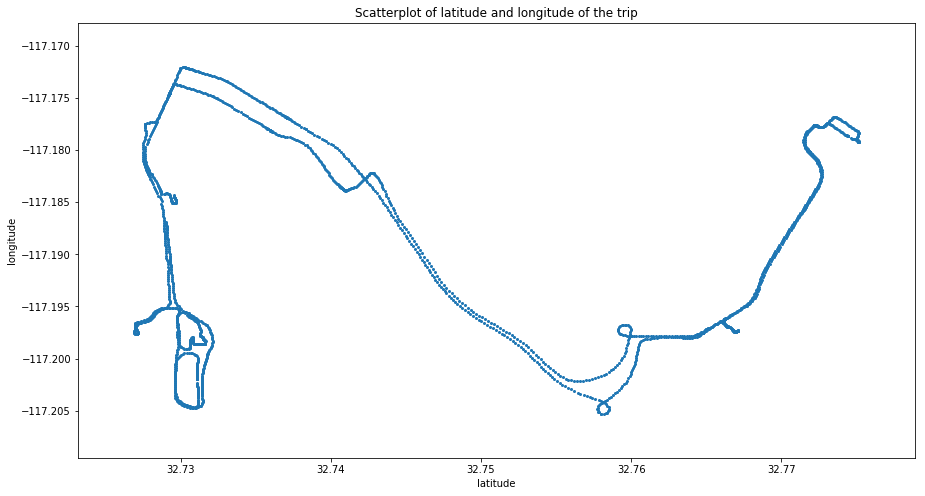

In [129]:
plt.figure(figsize = (15,8))
plt.scatter(gps_df['latitude'], gps_df['longitude'], s=4, marker='o')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Scatterplot of latitude and longitude of the trip')

In [130]:
gps_df['lat_rad'] = np.radians(gps_df['latitude'])
gps_df['long_rad'] = np.radians(gps_df['longitude'])

1
2
3
4
5
6
7
8
9
10
11
12
13
14


Text(0.5,1,u'Elbow Method For Optimal k')

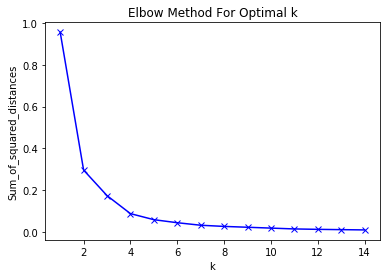

In [131]:
### Clustering
from sklearn.cluster import KMeans

# find optimal number of clusters
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    print(k)
    km = KMeans(n_clusters=k)
    km = km.fit(gps_df[['latitude', 'longitude']])
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')

#### Optimal number of clusters looks to be 5

In [132]:
kmeans = KMeans(5)
clusters = kmeans.fit_predict(gps_df[['latitude', 'longitude']])
gps_df['lat_long_cluster'] = kmeans.predict(gps_df[['latitude', 'longitude']])

In [133]:
gps_df['lat_long_cluster'].value_counts()

1    739
0    539
2    512
3    364
4    279
Name: lat_long_cluster, dtype: int64

Text(0.5,1,u'Scatterplot of latitude and longitude of the trip')

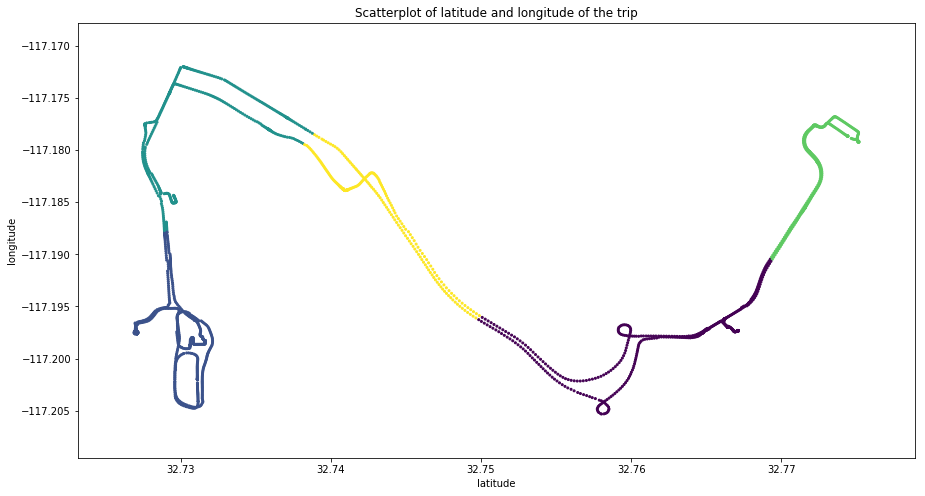

In [134]:
plt.figure(figsize = (15,8))
plt.scatter(gps_df['latitude'], gps_df['longitude'], s=4, marker='o', c=gps_df['lat_long_cluster'])
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Scatterplot of latitude and longitude of the trip')

In [135]:
# distance feature

def haversine_distance(row):
    lat_p, lon_p = row['latitude_shift'], row['longitude_shift']
    lat_d, lon_d = row['latitude'], row['longitude']
    radius = 6371 # km

    dlat = np.radians(lat_d - lat_p)
    dlon = np.radians(lon_d - lon_p)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat_p)) * np.cos(np.radians(lat_d)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = radius * c

    return distance

In [136]:
gps_df['latitude_shift'] = gps_df['latitude'].shift(1)
gps_df['longitude_shift'] = gps_df['longitude'].shift(1)
gps_df.loc[0, 'latitude_shift'] = gps_df.loc[0, 'latitude']
gps_df.loc[0, 'longitude_shift'] = gps_df.loc[0, 'longitude']

gps_df['haversine_distance'] = gps_df.apply(haversine_distance, axis=1)

In [137]:
gps_df.head()

,vertical_accuracy,course,driver_id,horizontal_accuracy,latitude,timestamp,altitude,raw_speed,heading,longitude,time_diff,lat_rad,long_rad,lat_long_cluster,latitude_shift,longitude_shift,haversine_distance
0,3,273,NzUxNWQwMjBk,10,32.729043,2016-10-05 18:58:29.188,-3,7.860000,149,-117.186911,0,0.57123,-2.045297,2,32.729043,-117.186911,0.000000
1,3,273,NzUxNWQwMjBk,10,32.729047,2016-10-05 18:58:30.000,-3,6.409999,241,-117.186987,812,0.57123,-2.045299,2,32.729043,-117.186911,0.007169
2,3,273,NzUxNWQwMjBk,10,32.729050,2016-10-05 18:58:31.000,-3,6.030000,241,-117.187045,1812,0.57123,-2.045300,2,32.729047,-117.186987,0.005465
3,3,273,NzUxNWQwMjBk,10,32.729054,2016-10-05 18:58:32.000,-3,5.800000,241,-117.187111,2812,0.57123,-2.045301,2,32.729050,-117.187045,0.006125
4,3,273,NzUxNWQwMjBk,10,32.729057,2016-10-05 18:58:33.000,-3,6.420000,241,-117.187174,3812,0.57123,-2.045302,2,32.729054,-117.187111,0.005914


In [138]:
# merge gps_df and motion_feats_df
gps_cols = ['lat_rad', 'long_rad', 'lat_long_cluster', 'raw_speed', 'haversine_distance']
gps_df.rename(columns={'time_diff': 'gps_ts_key'}, inplace=True)
motion_feats_df = pd.merge(motion_feats_df, gps_df[gps_cols+['gps_ts_key']], on='gps_ts_key', how='left')

motion_feats_df.isnull().sum()

timestamp                                                    0
proximity                                                    0
driver_id                                                    0
ZM_pitch                                                     0
gyroscope_y                                                  0
gyroscope_x                                                  0
gyroscope_z                                                  0
ZM_acceleration_z                                            0
ZM_acceleration_y                                            0
ZM_acceleration_x                                            0
ZM_yaw                                                       0
ZM_roll                                                      0
time_diff                                                    0
anomaly                                                      0
ZM_acceleration_x_sqd                                        0
ZM_acceleration_y_sqd                                  

In [145]:
def feature_creation_gps(data, num_cols=['lat_rad', 'long_rad', 'raw_speed', 'haversine_distance'],
                         cat_cols=['lat_long_cluster'],
                         top_motion_feats=['ZM_roll', 'ZM_pitch', 'ZM_yaw', 'ZM_acceleration_x_sqd',
                                           'ZM_acceleration_y_sqd', 'ZM_acceleration',
                                           'ZM_acceleration_y_mean_acceleration_z_diff_acceleration_x',
                                           'ZM_acceleration_x_sqd_sum_acceleration_y_sqd',
                                           'ZM_acceleration_x_sqd_sum_acceleration_z_sqd',
                                           'ZM_acceleration_y_sqd_sum_acceleration_z_sqd'],
                         feat_prefix='ZG_'):
    df = data.copy()
    
    print('Summary stats for numeric variables\n')
    simple = {'min': np.nanmin, 'max': np.nanmax, 'average': np.nanmean, 'perc50': np.nanmedian, 'std': np.nanstd,
              'perc25': lambda x: np.percentile(x, 25), 'perc75': lambda x: np.percentile(x, 75)}
    stats = {}
    for col in num_cols:
        print(col)
        stats[col] = {}
        for k, fn in simple.items():
            stats[col][k] = fn(df[col])
            
        stats[col]['mean+sd'] = stats[col]['average'] + stats[col]['std']
        stats[col]['mean-sd'] = stats[col]['average'] - stats[col]['std']
        stats[col]['mean+2sd'] = stats[col]['average'] + 2*stats[col]['std']
        stats[col]['mean-2sd'] = stats[col]['average'] - 2*stats[col]['std']
        stats[col]['mean+3sd'] = stats[col]['average'] + 3*stats[col]['std']
        stats[col]['mean-3sd'] = stats[col]['average'] - 3*stats[col]['std']
    print('\n')
    
    print('Ratio features\n')
    ratio_cols = []
    for col in num_cols:
        print(col)
        stat = stats[col]
        for func_name in ['min', 'max', 'average', 'perc50', 'perc25', 'perc75']:
            df[col+'_ratio_'+func_name] = 1.*df[col]/stat[func_name]
            ratio_cols.append(col+'_ratio_'+func_name)
            
        for func1, func2, name in [('mean+sd', 'mean-sd', 1), ('mean+2sd', 'mean-2sd', 2),
                                   ('mean+3sd', 'mean-3sd', 3)]:
            df[col+'_flag_'+str(name)] = df[col].apply(lambda x: 1 if (x > stat[func1]) or (x < stat[func2]) else 0)
            ratio_cols.append(col+'_flag_'+str(name))
            
    print('Encode categorical variables by aggregating numeric variables\n')
    all_cols = num_cols + top_motion_feats
    cat_enc_cols = []
    for cat_col in cat_cols:
        for num_col in all_cols:
            for func in ['mean', 'sum']:
                feat_name = '_'.join([func, num_col, 'per', cat_col])
                print(feat_name)
                df[feat_name] = df.groupby([cat_col])[num_col].transform(func)
                cat_enc_cols.append(feat_name)
                print('\n')
                
    print('prefix for features\n')
    feat_cols = num_cols + ratio_cols + cat_enc_cols + cat_cols
    print('# GPS features: %d' % (len(feat_cols)))
    new_feat_cols = [feat_prefix+x for x in feat_cols]
    rename_dct = dict(zip(feat_cols, new_feat_cols))
    df.rename(columns=rename_dct, inplace=True)
    
    return df

In [146]:
%time motion_gps_feats_df = feature_creation_gps(motion_feats_df)

Summary stats for numeric variables

lat_rad
long_rad
raw_speed
haversine_distance


Ratio features

lat_rad
long_rad
raw_speed
haversine_distance
Encode categorical variables by aggregating numeric variables

mean_lat_rad_per_lat_long_cluster


sum_lat_rad_per_lat_long_cluster


mean_long_rad_per_lat_long_cluster


sum_long_rad_per_lat_long_cluster


mean_raw_speed_per_lat_long_cluster


sum_raw_speed_per_lat_long_cluster


mean_haversine_distance_per_lat_long_cluster


sum_haversine_distance_per_lat_long_cluster


mean_ZM_roll_per_lat_long_cluster


sum_ZM_roll_per_lat_long_cluster


mean_ZM_pitch_per_lat_long_cluster


sum_ZM_pitch_per_lat_long_cluster


mean_ZM_yaw_per_lat_long_cluster


sum_ZM_yaw_per_lat_long_cluster


mean_ZM_acceleration_x_sqd_per_lat_long_cluster


sum_ZM_acceleration_x_sqd_per_lat_long_cluster


mean_ZM_acceleration_y_sqd_per_lat_long_cluster


sum_ZM_acceleration_y_sqd_per_lat_long_cluster


mean_ZM_acceleration_per_lat_long_cluster


sum_ZM_acceleration_per

### Modelling - feature set comes from both Motion and GPS data

In [147]:
print('prepare data for modelling\n')
feat_cols = [x for x in list(motion_gps_feats_df.columns) if (x.startswith('ZM_')) or (x.startswith('ZG_'))]
print('# features: ', len(feat_cols))
x_train = motion_gps_feats_df[feat_cols]
y_train = motion_gps_feats_df['anomaly']
print('shape ', x_train.shape, y_train.shape)

prepare data for modelling

('# features: ', 259)
('shape ', (14671, 259), (14671L,))


In [148]:
# XGB
params = {'rounds': 1000, 'depth': 3, 'eta': 0.05}
start = time.time()
pred_val_full, auc, pred_test_full, cv_scores = trainModel(x_train, y_train, None, 5, "XGB", feat_cols, **params)
print('time taken: %0.2f' % (time.time() - start))

[0]	train-auc:0.859985	test-auc:0.815741
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 100 rounds.
[20]	train-auc:0.935051	test-auc:0.890803
[40]	train-auc:0.94962	test-auc:0.911283
[60]	train-auc:0.967541	test-auc:0.933276
[80]	train-auc:0.977677	test-auc:0.9433
[100]	train-auc:0.982979	test-auc:0.952976
[120]	train-auc:0.985637	test-auc:0.959502
[140]	train-auc:0.987365	test-auc:0.961277
[160]	train-auc:0.988455	test-auc:0.96264
[180]	train-auc:0.98971	test-auc:0.964725
[200]	train-auc:0.990803	test-auc:0.964754
[220]	train-auc:0.991913	test-auc:0.964917
[240]	train-auc:0.992712	test-auc:0.964917
[260]	train-auc:0.993395	test-auc:0.964882
[280]	train-auc:0.994155	test-auc:0.965521
[300]	train-auc:0.994768	test-auc:0.966308
[320]	train-auc:0.995365	test-auc:0.96683
[340]	train-auc:0.995839	test-auc:0.966584
[360]	train-auc:0.996365	test-auc:0.966717
[380]	train-auc:0.99686	test-auc:0.966687
[400]	train

In [149]:
print(cv_scores)
print('Overall AUC: ', auc)

[0.9670115666063419, 0.978391154867948, 0.976007002306048, 0.9733903734958587, 0.981619969855264]
('Overall AUC: ', 0.975743813571341)


In [150]:
thresholds = [x/100. for x in range(50)]
metrics_df = calc_prec_rec(y_train, pred_val_full, thresholds)
print('Best FScore\n')
metrics_df[metrics_df['fscore'] == metrics_df['fscore'].max()]

('Threshold: ', 0.0)
('Precision: ', 0.0300593006591194)
('Recall: ', 0.9999999977324263)
('FScore: ', 0.058364213862048146)


('Threshold: ', 0.01)
('Precision: ', 0.16363636357438016)
('Recall: ', 0.9795918345133972)
('FScore: ', 0.2804284321451292)


('Threshold: ', 0.02)
('Precision: ', 0.220392989792675)
('Recall: ', 0.9410430817663422)
('FScore: ', 0.35714285683550523)


('Threshold: ', 0.03)
('Precision: ', 0.26230569931197817)
('Recall: ', 0.9183673448563099)
('FScore: ', 0.4080604529893598)


('Threshold: ', 0.04)
('Precision: ', 0.2965722799578448)
('Recall: ', 0.9024943290192873)
('FScore: ', 0.44643858615093823)


('Threshold: ', 0.05)
('Precision: ', 0.3285834029098211)
('Recall: ', 0.8888888868732678)
('FScore: ', 0.4798041609794318)


('Threshold: ', 0.06)
('Precision: ', 0.3563535908320869)
('Recall: ', 0.8775510184182517)
('FScore: ', 0.5068762272339539)


('Threshold: ', 0.07)
('Precision: ', 0.3757455264654617)
('Recall: ', 0.8571428551992225)
('FScore: ', 0.52246026

,fscore,prec,rec,threshold
27,0.606195,0.591793,0.621315,0.27


### Massive improvement in AUC, Precision, Recall and Fscore after including GPS features
1. AUC improved from 0.9408 (without GPS features) to 0.9757
2. Precision improved from 44.04% to 59.18%
3. Recall improved from 54.42% to 62.13%
4. Fscore improved from 48.68% to 60.62%

In [151]:
out_df = pd.DataFrame({'timestamp': motion_feats_df['timestamp'].values, 'DV': motion_feats_df['anomaly'].values})
out_df['pred_prob'] = pred_val_full
# pred_class corresponding to the best fscore
out_df['pred_class'] = out_df['pred_prob'].apply(lambda x: 1 if x >= 0.27 else 0)
# save
out_df.to_csv(os.path.join(OUT_DIR, 'predictions_Mxgb_Fmotion_and_gps.csv'), index=False)

In [152]:
### Save features DF (in case needed)
motion_feats_df.to_csv(os.path.join(INTER_DIR, 'motion_features_df.csv'), index=False)
motion_gps_feats_df.to_csv(os.path.join(INTER_DIR, 'motion_gps_features_df.csv'), index=False)